# Montar carpeta de drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install scikit-learn
#!pip install opencv-python
#!pip install matplotlib
#!pip install mlxtend



# Clasificador de imágenes

In [2]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
%matplotlib inline

# Configuración de parámetros

In [3]:
width_shape = 224
height_shape = 224
num_classes = 24
epochs = 100
batch_size = 32
image_shape = (224,224,3)

# Path de dataset

In [4]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\valid'

# Generador de imágenes (entrenamiento y validación) VGG19

In [8]:
# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Últimos cambios añadidos de una consulta
    rotation_range=10,
    zoom_range=0.1,  # Reducido de 0.2 a 0.1
    width_shift_range=0.1,  # Reducido de 0.2 a 0.1
    height_shift_range=0.1,  # Reducido de 0.2 a 0.1
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest', # Últimos cambios añadidos de una consulta
    )

valid_datagen = ImageDataGenerator(rescale=1./255) # Sin aumentos de datos para la validación

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 12396 images belonging to 24 classes.
Found 2564 images belonging to 24 classes.


# Entrenamiento de modelo 9

In [10]:
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

# Load pre-trained VGG19 model
image_input = Input(shape=(width_shape, height_shape, 3))
base_model = VGG19(input_tensor=image_input, include_top=False, weights='imagenet')

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Creating final model
custom_vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Freezing layers from original VGG19 model
for layer in base_model.layers:
    layer.trainable = False

# Compilando el modelo con Adam
custom_vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Definir ModelCheckpoint
checkpoint = ModelCheckpoint(r'C:\Users\johns\Desktop\TFG\Dataset\VGG19\best_vgg19_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con ModelCheckpoint
model_history = custom_vgg_model.fit(
    train_generator,
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(nb_validation_samples / batch_size),
    callbacks=[checkpoint,reduce_lr,early_stopping])

# Guardar el modelo
custom_vgg_model.save(r'C:\Users\johns\Desktop\TFG\Dataset\VGG19\custom_vgg19_model.h5')

Epoch 1/100
388/388 [==============================] - ETA: 0s - loss: 3.0771 - accuracy: 0.1234
Epoch 1: val_accuracy improved from -inf to 0.27106, saving model to C:\Users\johns\Desktop\TFG\Dataset\VGG19\best_vgg19_model.h5
388/388 [==============================] - 147s 367ms/step - loss: 3.0771 - accuracy: 0.1234 - val_loss: 2.4595 - val_accuracy: 0.2711 - lr: 0.0010
Epoch 2/100
388/388 [==============================] - ETA: 0s - loss: 2.6047 - accuracy: 0.1781
Epoch 2: val_accuracy improved from 0.27106 to 0.32488, saving model to C:\Users\johns\Desktop\TFG\Dataset\VGG19\best_vgg19_model.h5
388/388 [==============================] - 127s 327ms/step - loss: 2.6047 - accuracy: 0.1781 - val_loss: 2.2449 - val_accuracy: 0.3249 - lr: 0.0010
Epoch 3/100
388/388 [==============================] - ETA: 0s - loss: 2.4487 - accuracy: 0.2191
Epoch 3: val_accuracy did not improve from 0.32488
388/388 [==============================] - 125s 321ms/step - loss: 2.4487 - accuracy: 0.2191 - val_

# Grabar modelo en disco

In [11]:
custom_vgg_model.save(r"C:\Users\johns\Desktop\TFG\Dataset\VGG19\custom_vgg19_model.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [12]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

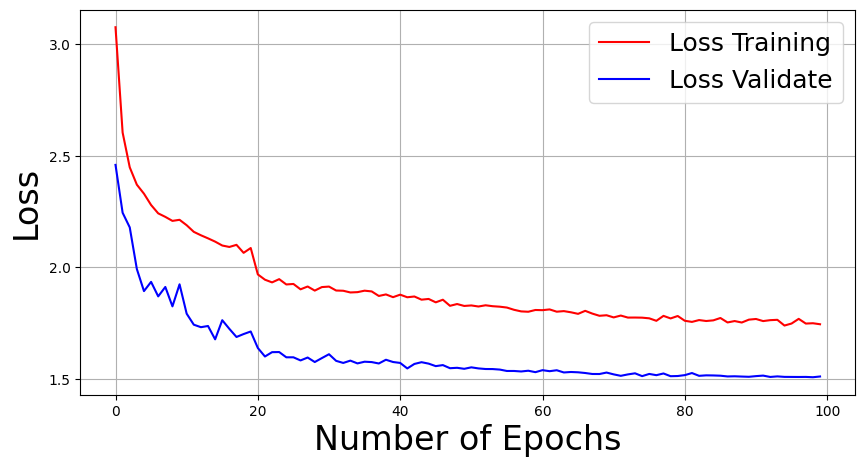

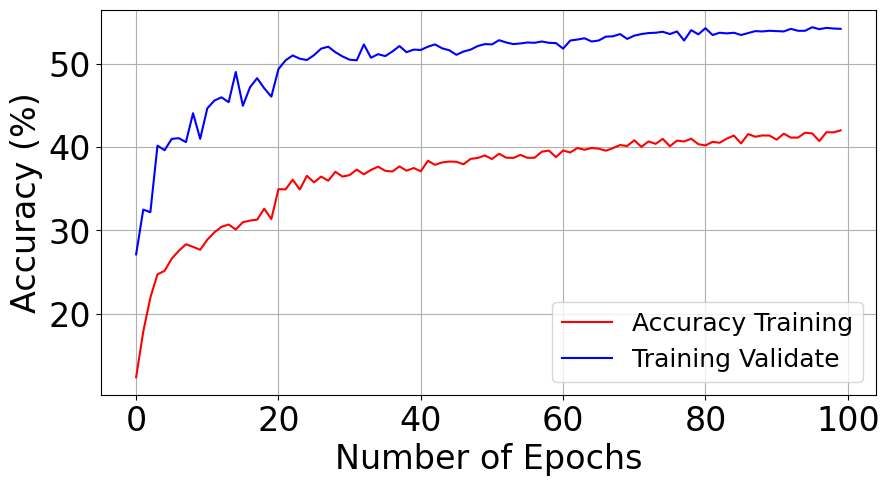

In [13]:
num_epochs_done = len(model_history.history['loss'])

plotTraining(model_history,num_epochs_done,"loss")
plotTraining(model_history,num_epochs_done,"accuracy")
plotTraining(model_history,num_epochs_done,"val_loss")
plotTraining(model_history,num_epochs_done,"val_accuracy")


# Predicción usando el modelo entrenado

AVEFRÍA EUROPEA


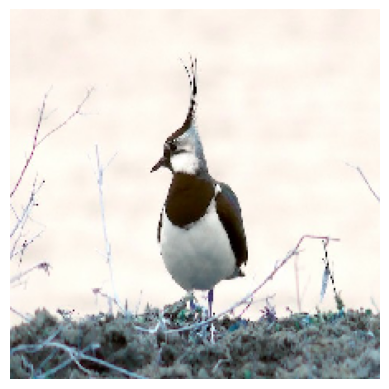

In [15]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA PICOFINA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

# cargar el modelo
modelt = load_model(r"C:\Users\johns\Desktop\TFG\Dataset\VGG19\best_vgg19_model.h5")

# ruta de la imagen
imaget_path = r"C:\Users\johns\Desktop\TFG\Dataset\test\AVEFRÍA EUROPEA\14.jpg"

# cargar y redimensionar la imagen
imaget = load_img(imaget_path, target_size=(width_shape, height_shape))
imaget = img_to_array(imaget)
imaget = imaget.reshape((1,) + imaget.shape)

 # Normalizar la imagen
xt = imaget / 255.0 

# hacer predicciones
preds = modelt.predict(xt)

# obtener la clase predicha
predicted_class = np.argmax(preds)
class_name = names[predicted_class]

print(class_name)

# mostrar la imagen
plt.imshow(cv2.cvtColor(imaget.reshape(width_shape, height_shape, 3).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 1873 images belonging to 24 classes.


C:\Users\johns\AppData\Local\Temp\ipykernel_7628\1653275593.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs\

              precision    recall  f1-score   support

           0     0.7045    0.4960    0.5822       125
           1     0.9091    0.0833    0.1527       120
           2     0.6500    0.4333    0.5200       120
           3     0.6250    0.0476    0.0885       105
           4     0.4262    0.4333    0.4298        60
           5     0.5000    0.0602    0.1075        83
           6     0.6857    0.4000    0.5053        60
           7     0.3628    0.5325    0.4316        77
           8     0.6042    0.5800    0.5918        50
           9     0.3229    0.4429    0.3735        70
          10     0.6316    0.7500    0.6857        80
          11     0.4348    0.1053    0.1695        95
          12     0.0000    0.0000    0.0000         6
          13     0.2803    0.6471    0.3911        68
          14     0.2071    0.6406    0.3130        64
          15     0.1579    0.0462    0.0714        65
          16     0.2353    0.2286    0.2319        70
          17     0.2267    

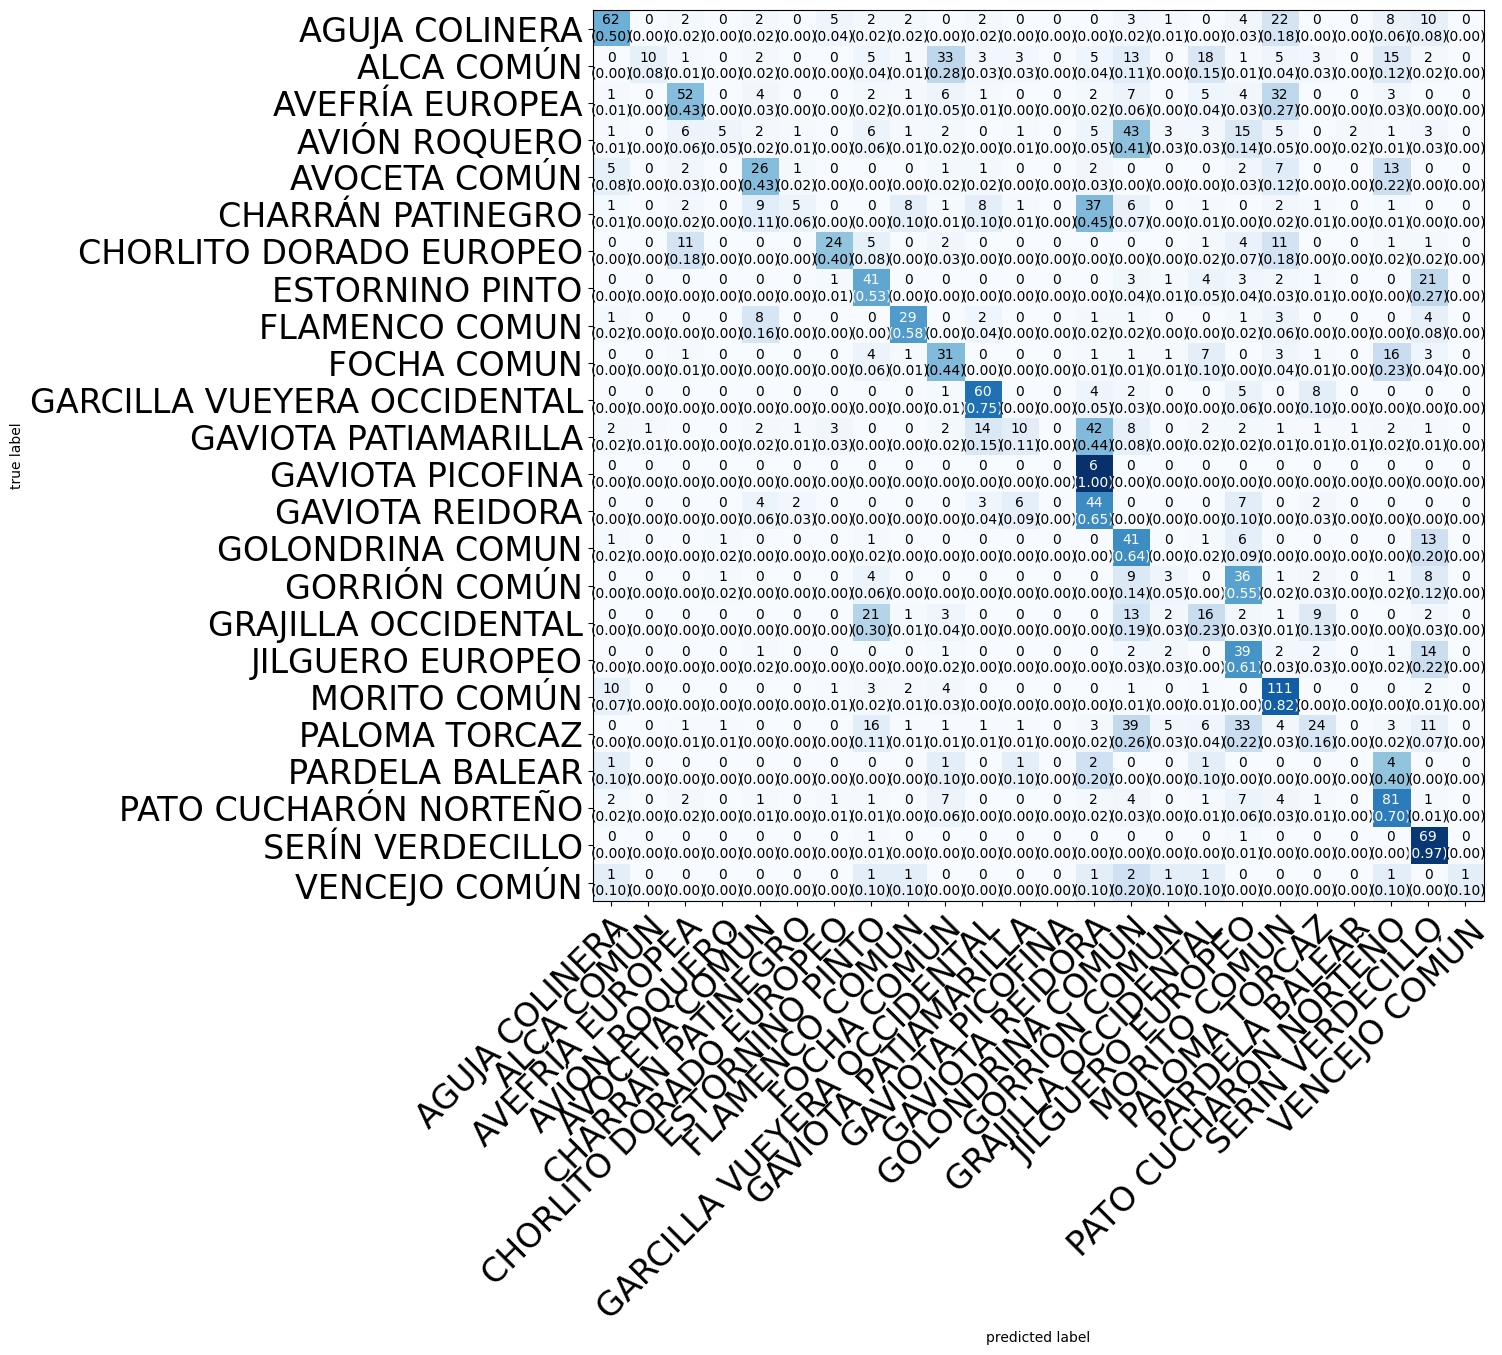

In [17]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA PICOFINA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

test_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False)

custom_Model= load_model(r"C:\Users\johns\Desktop\TFG\Dataset\VGG19\best_vgg19_model.h5")
predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

matc=confusion_matrix(y_real, y_pred)

#show_normed: es para normalizar la salida de la matriz de confusion entre 0 y 1.
plot_confusion_matrix(conf_mat=matc, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

In [18]:
print(y_real)

[ 0  0  0 ... 23 23 23]


In [19]:
print(y_pred)

[21 21 21 ... 21 14 16]
